In [1]:
import numpy as np
import glob, os
import xarray as xr
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely.geometry as sgeom
import matplotlib.patheffects as path_effects
%matplotlib inline

In [2]:
# datadir = '/global/cscratch1/sd/feng045/waccem/mcs_global/'
# reg0 = 'tropical_eastern_pacific'
# reg1 = 'china'
# reg2 = 'maritime_continent'
# reg3 = 'eus'
# # datafile0 = f'{datadir}{reg0}/mcstracking/20150101_20150331/mcstrack_20150101_0130.nc'
# datafile1 = f'{datadir}{reg1}/mcstracking/20150101_20150331/mcstrack_20150101_0130.nc'
# datafile2 = f'{datadir}{reg2}/mcstracking/20150101_20150331/mcstrack_20150101_0130.nc'
# datafile3 = f'{datadir}{reg3}/mcstracking/20150301_20151031/mcstrack_20150301_0100.nc'

topfile = '/global/project/projectdirs/m1867/zfeng/globe_topography/ETOPO1_Ice_g_gmt4.nc'

figdir = '/global/project/projectdirs/m1657/zfeng/cacti/imerg/results/'

In [3]:
dstop = xr.open_dataset(topfile)
dstop

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

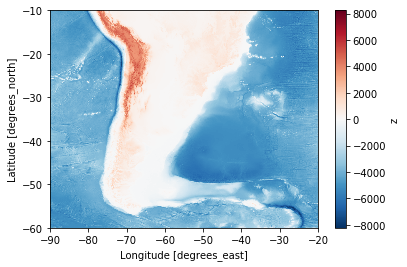

In [4]:
ter = dstop.z.sel(x=slice(-90,-20), y=slice(-60,-10))
lon = dstop.x.sel(x=slice(-90,-20))
lat = dstop.y.sel(y=slice(-60,-10))
landmask = ter >= 0
ter.plot()

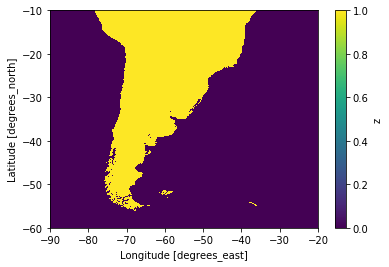

In [5]:
landmask.plot()

In [6]:
# lon_wrfbox = [-72.9671, -52.43289, -52.43289, -72.9671, -72.9671]
# lat_wrfbox = [-38.34014, -38.34014, -24.947563, -24.947563, -38.34014]

In [7]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
def compute_radius(proj, lat, lon, radius_degrees):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = proj.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

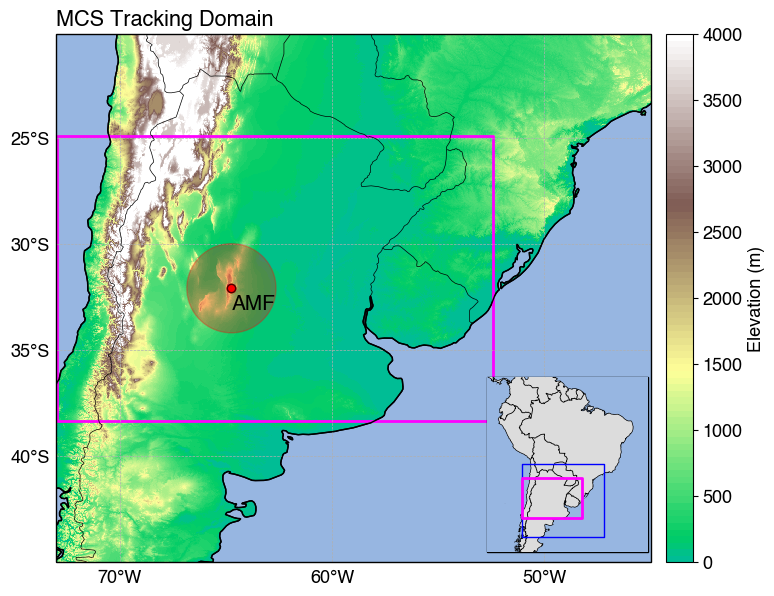

In [9]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

lonmin = -73
lonmax = -45
latmin = -45
latmax = -20.1
# map_extend = [-73, -45.1, -45, -20.1]
map_extend = [lonmin, lonmax, latmin, latmax]

lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,10))
latvals = mpl.ticker.FixedLocator(np.arange(-80,80.1,5))
levelshgt = [1000,2000]

fig = plt.figure(figsize=[10,7], dpi=100)
# fig = plt.figure(figsize=[15,5], dpi=100)
resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
proj = ccrs.PlateCarree()
ax = plt.subplot(projection=proj)
ax.set_extent(map_extend, crs=proj)
ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Shade terrain height
levels = np.arange(0,4000.1,50)
cbticks = np.arange(0,4000.1,500)
cmap = plt.get_cmap('terrain')
cmap = truncate_colormap(cmap, 0.22, 1)
# Zm = np.ma.masked_where(((ter < 0) | (np.isnan(ter))), ter)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
cf1 = plt.pcolormesh(lon, lat, ter, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
cb = plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
ax.set_title('MCS Tracking Domain', loc='left')

# AMF site
lon_amf = -64.75
lat_amf = -32.1
ax.plot(lon_amf, lat_amf, color='red', marker='o', markersize=6)
ax.plot(lon_amf, lat_amf, color='k', marker='o', markersize=6, fillstyle='none')
ax.text(lon_amf, lat_amf-1, 'AMF', color='k', fontsize=15, zorder=10)

# Compute the required radius in projection native coordinates:
# r_proj = compute_radius(proj, lat_amf, lon_amf, 0.1)
r_proj = 2.1
# Draw a patch circle
ax.add_patch(mpatches.Circle(xy=[lon_amf, lat_amf], radius=r_proj, color='red', alpha=0.3, transform=proj, zorder=6))

# Create an inset GeoAxes showing the location of the domain
sub_ax = plt.axes([0.56, 0.14, 0.25, 0.25], projection=proj)
sub_ax.set_extent([-85, -30, -50, 10], proj)
# # Make a nice border around the inset axes.
# effect = path_effects.Stroke(linewidth=4, foreground='wheat', alpha=0.5)
# sub_ax.outline_patch.set_path_effects([effect])
    
# Add land, coastlines, borders to inset
sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k', zorder=4)
sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'], zorder=4)
sub_ax.add_feature(borders, edgecolor='k', facecolor='none', lw=0.6, zorder=4)
# sub_ax.add_feature(rivers, facecolor='None', linewidth=1.5, edgecolor='b', zorder=3)
# Plot a box to show the domain
# sub_ax.plot([lonmin,lonmax,lonmax,lonmin,lonmin], [latmin,latmin,latmax,latmax,latmin], color='b', lw=1, zorder=5, transform=proj)
gpm_domain = sgeom.box(minx=lonmin, maxx=lonmax, miny=latmin, maxy=latmax)
sub_ax.add_geometries([gpm_domain], proj, facecolor='none', edgecolor='b', lw=1, zorder=5)

# WRF domain
wrf_lonmin, wrf_lonmax = -72.9671, -52.43289
wrf_latmin, wrf_latmax = -38.34014, -24.947563
# ax.plot(lon_wrfbox, lat_wrfbox, color='magenta', lw=2, transform=proj)
# sub_ax.plot(lon_wrfbox, lat_wrfbox, color='magenta', lw=2, zorder=5, transform=proj)
wrf_domain = sgeom.box(minx=wrf_lonmin, maxx=wrf_lonmax, miny=wrf_latmin, maxy=wrf_latmax)
ax.add_geometries([wrf_domain], proj, facecolor='none', edgecolor='magenta', lw=2)
sub_ax.add_geometries([wrf_domain], proj, facecolor='none', edgecolor='magenta', lw=2, zorder=5)

# sub_ax.text(-55, -13, 'Brazil', color='k', fontsize=18, fontweight='bold', zorder=5, transform=proj)
# ax.set_aspect('auto', adjustable=None)
# plt.tight_layout()

# figname = f'{figdir}imerg_mcs_tracking_map_CACTI.png'
figname = f'{figdir}CACTI_mcs_tracking_map_imerg_wrf.png'
fig.savefig(figname, dpi=300, bbox_inches='tight')

In [ ]:
# mpl.rcParams['font.size'] = 13
# mpl.rcParams['font.family'] = 'Helvetica'

# map_extend = [-80, -30.1, -50, -15.1]
# lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,10))
# latvals = mpl.ticker.FixedLocator(np.arange(-80,80.1,5))
# levelshgt = [1000,2000]

# fig = plt.figure(figsize=[10,7], dpi=100)

# resolution = '50m'
# land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
# ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
# borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
# fig = plt.figure(figsize=[15,5], dpi=100)

# proj = ccrs.PlateCarree()
# ax = plt.subplot(projection=proj)
# ax.set_extent(map_extend, crs=proj)
# ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
# ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.5, zorder=5)
# # ax.stock_img()
# # ax.add_feature(ocean, facecolor='lightskyblue', edgecolor='k')
# ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)

# gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = lonvals
# gl.ylocator = latvals
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# # colors = ['red','green','blue','darkorange','purple','magenta','tomato',
# #           'forestgreen','firebrick','royalblue','royalblue','darkorange','darkgreen','blue',
# #           'orangered','orangered','royalblue','purple','orangered','purple']
# # # Box outline
# # ax.plot(lon9box, lat9box, transform=proj, color=colors[8], ls='--')

# # # Fill color
# # ax.fill(lon9box, lat9box, transform=proj, color=colors[8], alpha=0.4)

# # Shade terrain height
# levels = np.arange(0,4000.1,50)
# cbticks = np.arange(0,4000.1,500)
# cmap = plt.get_cmap('terrain')
# cmap = cmap = truncate_colormap(cmap, 0.22, 1)
# # Zm = np.ma.masked_where(((ter < 0) | (np.isnan(ter))), ter)
# norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
# cf1 = plt.pcolormesh(lon, lat, ter, norm=norm, vmin=np.min(levels), vmax=np.max(levels), cmap=cmap, transform=proj)
# plt.colorbar(cf1, label='Elevation (m)', pad=0.02, ticks=cbticks)
# # ax.set_title(titles[pp], loc='left')

# # AMF site
# lon_amf = -64.75
# lat_amf = -32.1
# plt.plot(lon_amf, lat_amf, color='red', marker='o', markersize=10)
# plt.plot(lon_amf, lat_amf, color='k', marker='o', markersize=10, fillstyle='none')
# plt.text(lon_amf, lat_amf-3, 'AMF', color='k', fontsize=15)

# # Compute the required radius in projection native coordinates:
# # r_proj = compute_radius(proj, lat_amf, lon_amf, 0.1)
# r_proj = 2.3
# # Draw a patch circle
# ax.add_patch(mpatches.Circle(xy=[lon_amf, lat_amf], radius=r_proj, color='red', alpha=0.3, transform=proj, zorder=6))

# # ax.set_aspect('auto', adjustable=None)

# plt.tight_layout(w_pad=2.5, h_pad=1.2)
# figname = f'{figdir}mcs_southamerica_map.png'
# fig.savefig(figname, dpi=300, bbox_inches='tight')